with some reference to 
* https://www.kaggle.com/code/lingyixia/resnet18-base
* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

## Setting Up

In [1]:
import copy
from datetime import datetime
import io
from matplotlib import pyplot as plt
import numpy as np
import os.path
import pandas as pd
from pdb import set_trace as st
from PIL import Image
from sklearn.metrics import f1_score
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms , models
from torch.optim import SGD


In [2]:
np.random.seed(21052) # ふlo五二
torch.manual_seed(21052)
device = 'cuda'
DATA_PATH = '../data/tfrecords-jpeg-512x512/' # can ignore the rest; they're all the same except resolution.
MODEL_WEIGHTS_PATH = './models/'

In [3]:
class FlowerDataset(Dataset):
    def __init__(self, images, classes, ids, transform, mode):
        self.images = images
        self.classes = classes
        self.ids = ids
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = Image.open(io.BytesIO(self.images[idx]))
        img = self.transform(img)
        if self.mode == "test":
            idd = self.ids[idx]
            return (img, idd)
        else:
            label = self.classes[idx]
            return (img, label)
        
feats = {
    'train': {
        'class': tf.io.FixedLenFeature([], tf.int64),
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    },
    'val': {
        'class': tf.io.FixedLenFeature([], tf.int64),
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    },
    'test': {
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    }
}

data_elems = {
    'train': {'ids': [], 'images': [], 'classes': []},
    'val': {'ids': [], 'images': [], 'classes': []},
    'test': {'ids': [], 'images': []}
}

transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # https://pytorch.org/hub/pytorch_vision_resnet/
])

for dset_name in ['train', 'val', 'test']:
    dataset_path = os.path.join(DATA_PATH, dset_name)
    data_list = map(lambda path: tf.data.TFRecordDataset(os.path.join(dataset_path, path)), os.listdir(dataset_path))
    for tl in data_list:
        for t in tl.map(lambda x: tf.io.parse_single_example(x, feats[dset_name])):
            data_elems[dset_name]['ids'].append(str(t["id"].numpy())[2:-1])
            data_elems[dset_name]['images'].append(t["image"].numpy())
            if dset_name != 'test':
                data_elems[dset_name]['classes'].append(t["class"].numpy())

train_ds = FlowerDataset(data_elems['train']['images'], data_elems['train']['classes'], None, transform, 'train')
val_ds = FlowerDataset(data_elems['val']['images'], data_elems['val']['classes'], None, transform, 'val')
test_ds = FlowerDataset(data_elems['test']['images'], None, data_elems['test']['ids'], transform, 'test')

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
def train_model(model, epochs=10, lr=0.0005, eval_every=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    losses = []
    val_f1s = []
    val_accs = []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs} at {datetime.now()}==========')
        
        model.train()
        total_iter_loss = 0
        for x, y in train_dl:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            y_pred_probs = model(x)
            loss = criterion(y_pred_probs, y)
            total_iter_loss += loss
            loss.backward()
            optimizer.step()
        
        print(f'Training loss was {total_iter_loss / len(train_ds)}')
        losses.append(total_iter_loss.cpu().detach().numpy().item())
        
        if epoch % eval_every == 0:
            model.eval()
            
            ys = []
            y_preds = []
            
            for x, y in val_dl:
                x = x.to(device)
                y = y.to(device)
                y_pred = torch.max(model(x), 1)[1]
                ys.append(y)
                y_preds.append(y_pred)
            
            y = torch.cat(ys).cpu()
            y_pred = torch.cat(y_preds).cpu()
            
            f1 = f1_score(y, y_pred, average='macro')
            val_f1s.append(f1)
            acc = torch.sum(y == y_pred).item()
            val_accs.append(acc)
            print(f'Validated with f1={f1} and acc={acc}/{len(y)}')
            
    return losses, val_f1s, val_accs

## ResNet18 with initialization

In [5]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=104, bias=True),
    nn.Softmax(dim=1)
)
resnet18 = resnet18.to(device)

losses = []
val_f1s = []
val_accs = []

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet18, epochs=25, lr=0.1)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet18, epochs=25, lr=0.05)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet18, epochs=25, lr=0.02)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-14 09:54:15.898017==========
Training loss was 0.07108781486749649
Validated with f1=0.01715193609484355 and acc=769/3712
Epoch 1/25 at 2022-12-14 09:59:06.893883==========
Training loss was 0.06968242675065994
Validated with f1=0.018366165085456004 and acc=785/3712
Epoch 2/25 at 2022-12-14 10:02:42.126226==========
Training loss was 0.06929579377174377
Validated with f1=0.028497752615533743 and acc=1010/3712
Epoch 3/25 at 2022-12-14 10:06:12.656285==========
Training loss was 0.06852374225854874
Validated with f1=0.030221164755278015 and acc=1052/3712
Epoch 4/25 at 2022-12-14 10:09:38.622202==========
Training loss was 0.06804725527763367
Validated with f1=0.03904721333669788 and acc=1172/3712
Epoch 5/25 at 2022-12-14 10:13:10.095300==========
Training loss was 0.06759592145681381
Validated with f1=0.05569762469499757 and acc=1317/3712
Epoch 6/25 at 2022-12-14 10:16:42.464832==========
Training loss was 0.06709662824869156
Validated with f1=0.05953120629234698 an

Exception ignored in: <function UniquePtr.__del__ at 0x0000020C12EFB1C0>
Traceback (most recent call last):
  File "C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 74, in __del__
    self.deleter(obj)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [8]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model(resnet18, epochs=25, lr=0.01)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

Epoch 0/25 at 2022-12-14 15:58:45.127569==========
Training loss was 0.06051061674952507
Validated with f1=0.3752191957160929 and acc=2507/3712
Epoch 1/25 at 2022-12-14 16:01:04.258622==========
Training loss was 0.06048086658120155
Validated with f1=0.3759285567168699 and acc=2500/3712
Epoch 2/25 at 2022-12-14 16:04:30.306462==========
Training loss was 0.06045164540410042
Validated with f1=0.37581677727931273 and acc=2510/3712
Epoch 3/25 at 2022-12-14 16:07:33.003003==========
Training loss was 0.06044040620326996
Validated with f1=0.37548295061853476 and acc=2506/3712
Epoch 4/25 at 2022-12-14 16:10:26.734002==========
Training loss was 0.06044003739953041
Validated with f1=0.37438379498297675 and acc=2502/3712
Epoch 5/25 at 2022-12-14 16:13:57.465240==========
Training loss was 0.06042325496673584
Validated with f1=0.37521647683262493 and acc=2507/3712
Epoch 6/25 at 2022-12-14 16:17:02.536331==========
Training loss was 0.060423050075769424
Validated with f1=0.37490131245832736 and 

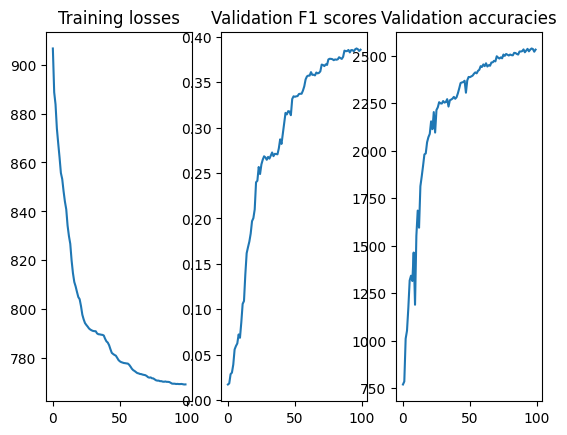

In [12]:

plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Training losses')
plt.subplot(1,3,2)
plt.plot(val_f1s)
plt.title('Validation F1 scores')
plt.subplot(1,3,3)
plt.plot(val_accs)
plt.title('Validation accuracies')
plt.show()

In [19]:
torch.save(resnet18.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet18'))

## ResNet152 with transfer learning

In [4]:
def train_model2(model, params, epochs=10, lr=0.0005, eval_every=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(params, lr=lr)
    
    losses = []
    val_f1s = []
    val_accs = []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs} at {datetime.now()}==========')
        
        model.train()
        total_iter_loss = 0
        for x, y in train_dl:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            y_pred_probs = model(x)
            loss = criterion(y_pred_probs, y)
            total_iter_loss += loss
            loss.backward()
            optimizer.step()
        
        print(f'Training loss was {total_iter_loss / len(train_ds)}')
        losses.append(total_iter_loss.cpu().detach().numpy().item())
        
        if epoch % eval_every == 0:
            model.eval()
            
            ys = []
            y_preds = []
            
            for x, y in val_dl:
                x = x.to(device)
                y = y.to(device)
                y_pred = torch.max(model(x), 1)[1]
                ys.append(y)
                y_preds.append(y_pred)
            
            y = torch.cat(ys).cpu()
            y_pred = torch.cat(y_preds).cpu()
            
            f1 = f1_score(y, y_pred, average='macro')
            val_f1s.append(f1)
            acc = torch.sum(y == y_pred).item()
            val_accs.append(acc)
            print(f'Validated with f1={f1} and acc={acc}/{len(y)}')
            
    return losses, val_f1s, val_accs

In [17]:
resnet152 = models.resnet152(pretrained=True)

resnet152.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=104, bias=True),
    nn.Softmax(dim=1)
)
resnet152 = resnet152.to(device)

losses = []
val_f1s = []
val_accs = []

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\thisi/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
98.0%


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [ ]:
losses_this_run, val_f1s_this_run, val_accs_this_run = train_model2(resnet152, resnet152.fc.parameters(), epochs=25, lr=0.1)
losses += losses_this_run
val_f1s += val_f1s_this_run
val_accs += val_accs_this_run

In [ ]:
plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Training losses')
plt.subplot(1,3,2)
plt.plot(val_f1s)
plt.title('Validation F1 scores')
plt.subplot(1,3,3)
plt.plot(val_accs)
plt.title('Validation accuracies')
plt.show()

In [ ]:
torch.save(resnet152.state_dict(), os.path.join(MODEL_WEIGHTS_PATH, 'resnet152'))

In [ ]:
temp_model = models.resnet18(pretrained=True)
tot_fr = temp_model.fc.in_features
temp_model.fc = nn.Linear(tot_fr , len(train_classes))
temp_model = ResNet18(192, 3, len(train_classes))
SERIAL_EXEC = xmp.MpSerialExecutor()
WRAPPED_MODEL = xmp.MpModelWrapper(temp_model)


def run(rank):
  train_sampler = torch.utils.data.distributed.DistributedSampler(
      train_ds , 
      num_replicas = 8 , 
      rank = xm.get_ordinal() , 
      shuffle = True , 
      seed = 0
  )
  val_sampler = torch.utils.data.distributed.DistributedSampler(
      val_ds , 
      num_replicas = 8 , 
      rank = xm.get_ordinal() , 
      shuffle = True , 
      seed = 0
  )
  train_loader = DataLoader(
      train_ds , 
      batch_size = 16 , 
      sampler = train_sampler , 
      num_workers = 1 , 
      drop_last = False
  )
  val_loader = DataLoader(
      val_ds , 
      batch_size = 16 , 
      sampler = val_sampler , 
      num_workers = 1 , 
      drop_last = False
  )
  test_loader = DataLoader(
      test_ds , 
      batch_size = 16 ,
      num_workers = 1 , 
      drop_last = False
  )
  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  lr = 0.01 * xm.xrt_world_size()
  optimizer = SGD(model.parameters() , lr = lr)
  loss_fn = nn.CrossEntropyLoss()

  num_epochs = 10

  for epoch in range(num_epochs):

    #training
    para_loader = pl.ParallelLoader(train_loader , [device])
    train_loss = []
    train_corr = 0
    train_sam = 0
    model.train()
    for x , (data , label) in enumerate(para_loader.per_device_loader(device)):
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output , label)
      #accuracy
      _ , pred = torch.max(output , 1)
      train_corr += (pred == label).sum()
      train_sam += label.shape[0]
      loss.backward()
      train_loss.append(loss.item())
      xm.optimizer_step(optimizer)
      
    #evaluation
    model.eval()
    val_loss = []
    val_corr = 0
    val_sam = 0
    with torch.no_grad():
      para_loader = pl.ParallelLoader(val_loader , [device])
      for x , (data , label) in enumerate(para_loader.per_device_loader(device)):
        output = model(data)
        loss = loss_fn(output , label)
        #accuracy
        _ , pred = torch.max(output , 1)
        val_corr += (pred == label).sum()
        val_sam += label.shape[0]
        val_loss.append(loss.item())

    t_ac = 100.0 * train_corr / train_sam
    v_ac = 100.0 * val_corr / val_sam
    t_lo = torch.sum(torch.Tensor(train_loss))
    v_lo = torch.sum(torch.Tensor(val_loss))
    
    print("epoch is ",epoch," train accu ",t_ac," train loss ",t_lo," val accu ",v_ac," val loss ",v_lo)
  
  if xm.is_master_ordinal():
    dic = {}
    model.eval()
    with torch.no_grad():
      para_loader = pl.ParallelLoader(test_loader , [device])
      for x , (data , ids) in enumerate(para_loader.per_device_loader(device)):
        output = model(data)
        _ , pred = torch.max(output , 1)
        for i in range(pred.shape[0]):
          dic[ids[i]] = int(pred[i].cpu().detach().numpy())
      df = pd.DataFrame(dic.items())
      df.to_csv("fin_sub.csv")
xmp.spawn(run , nprocs = 8 , start_method = "fork")
os.listdir()
dff = pd.read_csv('fin_sub.csv')
dff.head()
fin = pd.DataFrame({"id":dff["0"].values , "label":dff["1"].values})
fin.to_csv('submission.csv' , index = False)
os.listdir()
os.remove("fin_sub.csv")
fin.head()